In [2]:
# Earning Money in Cryptocurrency Markets by Spotting 
# Statistical Arbitrage Opportunities
#
# tested in Python 3.5.4
# (c) 2017, Dr. Pawel Lachowicz
 
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime
import json
from bs4 import BeautifulSoup
import requests
 
%matplotlib inline
grey = .6, .6, .6
 
 
# define a pair
fsym = "ETH"
tsym = "USD"
 
url = "https://min-api.cryptocompare.com/data/top/exchanges/full?fsym=" + \
       fsym + "&tsym=" + tsym
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
dic = json.loads(soup.prettify())
print(dic)


{'Response': 'Success', 'Message': 'Total available exchanges - 48', 'Data': {'CoinInfo': {'Id': '7605', 'Name': 'ETH', 'FullName': 'Ethereum', 'Internal': 'ETH', 'ImageUrl': '/media/20646/eth_logo.png', 'Url': '/coins/eth/overview', 'Algorithm': 'Ethash', 'ProofType': 'PoW', 'TotalCoinsMined': 104424456.0303, 'BlockNumber': 7082471, 'NetHashesPerSecond': 173330904468056, 'BlockReward': 3, 'BlockTime': 15, 'TotalVolume24H': 6466846.713199381}, 'AggregatedData': {'TYPE': '5', 'MARKET': 'CCCAGG', 'FROMSYMBOL': 'ETH', 'TOSYMBOL': 'USD', 'FLAGS': '4', 'PRICE': 121.94, 'LASTUPDATE': 1547743810, 'LASTVOLUME': 54.07477641, 'LASTVOLUMETO': 6534.3959813844, 'LASTTRADEID': '1547743810.7109', 'VOLUMEDAY': 446966.98393008066, 'VOLUMEDAYTO': 54329280.028903335, 'VOLUME24HOUR': 625979.5498263406, 'VOLUME24HOURTO': 76352464.30127871, 'OPENDAY': 123.12, 'HIGHDAY': 124.97, 'LOWDAY': 118.33, 'OPEN24HOUR': 122.54, 'HIGH24HOUR': 126.16, 'LOW24HOUR': 118.13, 'LASTMARKET': 'Kraken', 'VOLUMEHOUR': 70132.6502

In [18]:
market = []
d = dic['Data']['Exchanges']  # a list

for i in range(len(d)):
    market.append(d[i]['MARKET'])
    print(market[-1])

5
Bitfinex
Kraken
Coinbase
Bitstamp
P2PB2B


IndexError: list index out of range

In [4]:
vol = []
d = dic['Data']['Exchanges']  # a list
for i in range(len(d)):
    vol.append([d[i]['MARKET'], round(float(d[i]['VOLUME24HOUR']),2)])
 
# sort a list of sublists according to 2nd item in a sublist
vol = sorted(vol, key=lambda x: -x[1])
 
# Cryptocurrency Markets according to Volume traded within last 24 hours
for e in vol:
    print("%10s%15.2f" % (e[0], e[1]))

  Bitfinex      241564.16
    Kraken      140502.00
  Coinbase      115592.20
  Bitstamp       51323.51
    P2PB2B       44920.88


In [5]:
# Select Top 10 Cryptocurrency Markets
markets = [e[0] for e in vol][0:10]
print(markets)

['Bitfinex', 'Kraken', 'Coinbase', 'Bitstamp', 'P2PB2B']


In [6]:
def fetchCryptoOHLC_byExchange(fsym, tsym, exchange):
    # a function fetches a crypto OHLC price-series for fsym/tsym and stores
    # it in a pandas DataFrame; uses specific Exchange as provided
    # src: https://www.cryptocompare.com/api/
 
    cols = ['date', 'timestamp', 'open', 'high', 'low', 'close']
    lst = ['time', 'open', 'high', 'low', 'close']
 
    timestamp_today = datetime.today().timestamp()
    curr_timestamp = timestamp_today
 
    for j in range(2):
        df = pd.DataFrame(columns=cols)
        url = "https://min-api.cryptocompare.com/data/histoday?fsym=" + fsym + \
              "&tsym=" + tsym + "&toTs=" + str(int(curr_timestamp)) + \
              "&limit=2000" + "&e=" + exchange
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())
 
        for i in range(1, 2001):
            tmp = []
            for e in enumerate(lst):
                x = e[0]
                y = dic['Data'][i][e[1]]
                if(x == 0):
                    # timestamp-to-date
                    td = datetime.fromtimestamp(int(y)).strftime('%Y-%m-%d')
                    tmp.append(td)  #(str(timestamp2date(y)))
                tmp.append(y)
            if(np.sum(tmp[-4::]) > 0):
                df.loc[len(df)] = np.array(tmp)
        df.index = pd.to_datetime(df.date)
        df.drop('date', axis=1, inplace=True)
        curr_timestamp = int(df.iloc[0][0])
 
        if(j == 0):
            df0 = df.copy()
        else:
            data = pd.concat([df, df0], axis=0)
 
    return data.astype(np.float64)

In [7]:
# if a variable 'cp' exists, delete it
if ('cp' in globals()) or ('cp' in locals()): del cp
 
# download daily OHLC price-series for ETH/USD for a given 'market'
# extract close-price (cp)
 
print("%s/%s" % (fsym, tsym))
for market in markets:
    print("%12s... " % market, end="")
    df = fetchCryptoOHLC_byExchange(fsym, tsym, market)
    ts = df[(df.index > "2017-06-01") & (df.index <= "2017-11-05")]["close"]
    ts.name = market
    if ('cp' in globals()) or ('cp' in locals()):
        cp = pd.concat([cp, ts], axis=1, ignore_index=False)
    else:
        cp = pd.DataFrame(ts)
    print("downloaded")

ETH/USD
    Bitfinex... downloaded
      Kraken... downloaded
    Coinbase... downloaded
    Bitstamp... downloaded
      P2PB2B... downloaded


In [9]:
print(cp.head(10))
print(cp.tail(10))

            Bitfinex  Kraken  Coinbase  Bitstamp  P2PB2B
date                                                    
2017-06-02    217.01  224.23    224.95       NaN     NaN
2017-06-03    241.06  245.35    245.50       NaN     NaN
2017-06-04    242.16  247.60    248.00       NaN     NaN
2017-06-05    261.89  263.60    264.58       NaN     NaN
2017-06-06    250.70  256.19    255.68       NaN     NaN
2017-06-07    256.95  260.24    258.64       NaN     NaN
2017-06-08    278.41  279.85    279.38       NaN     NaN
2017-06-09    325.88  326.00    340.20       NaN     NaN
2017-06-10    336.33  333.10    343.01       NaN     NaN
2017-06-11    386.90  385.00    397.37       NaN     NaN
            Bitfinex  Kraken  Coinbase  Bitstamp  P2PB2B
date                                                    
2017-10-27    293.49  295.14    295.11       NaN     NaN
2017-10-28    304.39  303.95    303.38       NaN     NaN
2017-10-29    307.00  306.20    306.87       NaN     NaN
2017-10-30    303.69  304.12   

In [10]:
dist = []
for i in range(cp.shape[1]):
    for j in range(i):
        if(i != j):
            x = np.array(cp.iloc[:,i], dtype=np.float32)
            y = np.array(cp.iloc[:,j], dtype=np.float32)
            diff = np.abs(x-y)
            avg = np.mean(diff)
            std = np.std(diff, ddof=1)
            dist.append([cp.columns[i], cp.columns[j], avg, std])
 
dist = sorted(dist, key=lambda x: -x[2])
print("%10s%10s%10s%10s\n" % ("Coin1", "Coin2", "Mean", "Std Dev"))
for e in dist:
    print("%10s%10s%10.5f%10.2f" % (e[0], e[1], e[2], e[3]))

     Coin1     Coin2      Mean   Std Dev

    Kraken  Bitfinex   2.13962      2.71
  Coinbase  Bitfinex   2.05573      2.78
  Coinbase    Kraken   1.52822      2.52
  Bitstamp  Bitfinex       nan       nan
  Bitstamp    Kraken       nan       nan
  Bitstamp  Coinbase       nan       nan
    P2PB2B  Bitfinex       nan       nan
    P2PB2B    Kraken       nan       nan
    P2PB2B  Coinbase       nan       nan
    P2PB2B  Bitstamp       nan       nan


157 157


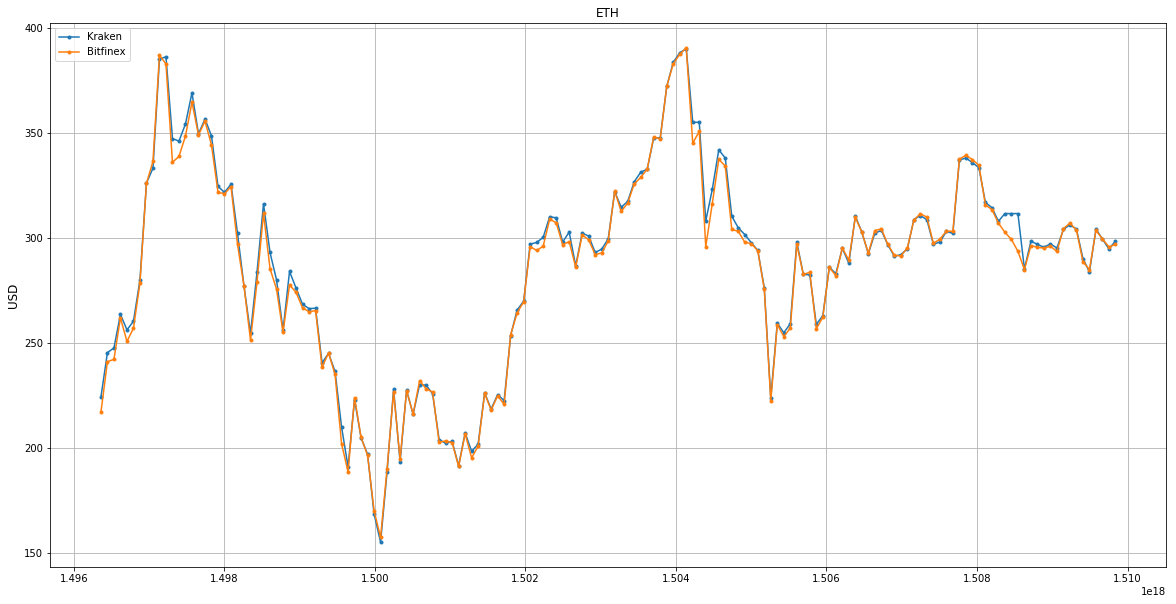

In [11]:
market1 = "Kraken"
market2 = "Bitfinex"
 
df1 = fetchCryptoOHLC_byExchange(fsym, tsym, market1)
df2 = fetchCryptoOHLC_byExchange(fsym, tsym, market2)
 
# trim
df1 = df1[(df1.index > "2017-06-01") & (df1.index <= "2017-11-05")]
df2 = df2[(df2.index > "2017-06-01") & (df2.index <= "2017-11-05")]
 
# checkpoint
print(df1.close.shape[0], df2.close.shape[0])  # both sizes must be equal
 
# plotting
plt.figure(figsize=(20,10))
plt.plot(df1.close, '.-', label=market1)
plt.plot(df2.close, '.-', label=market2)
plt.legend(loc=2)
plt.title(fsym, fontsize=12)
plt.ylabel(tsym, fontsize=12)
plt.grid()

In [13]:
# Backtesting Stat Arb trading strategy for ETH/USD at Exmo and Kraken
#  cryptocurrency exchanges
 
# initial parameters
investment = 10000  # USD
account1, account2 = investment/2, investment/2  # USD
position = 0.5*(investment/2)  # USD
 
roi = []
ac1 = [account1]
ac2 = [account2]
money = []
pnl_exch1 = []
pnl_exch2 = []
trade_pnl = []
 
trade = False
n = df1.close.shape[0]  # number of data points
 
# running the backtest
for i in range(n):
    p1 = float(df1.close.iloc[i])
    p2 = float(df2.close.iloc[i])
    if(p1 > p2):
        asset1 = "SHORT"
        asset2 = "LONG"
        if(trade == False):
            open_p1 = p1  # open prices
            open_p2 = p2
            open_asset1 = asset1
            open_asset2 = asset2
            trade = True
            print("new traded opened")
            new_trade = False
        elif(asset1 == open_asset1):
            new_trade = False  # flag
        elif(asset1 == open_asset2):
            new_trade = True   # flag
 
    elif(p2 > p1):
        asset1 = "LONG"
        asset2 = "SHORT"
        if(trade == False):
            open_p1 = p1  # open prices
            open_p2 = p2
            open_asset1 = asset1
            open_asset2 = asset2
            trade = True
            print("new traded opened")
            new_trade = False
        elif(asset1 == open_asset1):
            new_trade = False  # flag
        elif(asset1 == open_asset2):
            new_trade = True   # flag
 
    if(i == 0):
        print(df1.close.iloc[i], df2.close.iloc[i], \
              asset1, asset2, trade, "----first trade info")
    else:
        if(new_trade):
 
            # close current position
            if(open_asset1 == "SHORT"):
                # PnL of both trades
                pnl_asset1 = open_p1/p1 - 1
                pnl_asset2 = p2/open_p2 -1
                pnl_exch1.append(pnl_asset1)
                pnl_exch2.append(pnl_asset2)
                print(open_p1, p1, open_p2, p2, open_asset1, \
                      open_asset2, pnl_asset1, pnl_asset2)
                # update both accounts
                account1 = account1 + position*pnl_asset1
                account2 = account2 + position*pnl_asset2
                print("accounts [USD] = ", account1, account2)
                if((account1 <=0) or (account2 <=0)):
                    print("--trading halted")
                    break
                # return on investment (ROI)
                total = account1 + account2
                roi.append(total/investment-1)
                ac1.append(account1)
                ac2.append(account2)
                money.append(total)
                print("ROI = ", roi[-1])
                print("trade closed\n")
                trade = False
 
                # open a new trade
                if(asset1 == "SHORT"):
                    open_p1 = p1
                    open_p2 = p2
                    open_asset1 = asset1
                    open_asset2 = asset2
                else:
                    open_p1 = p1
                    open_p2 = p2
                    open_asset1 = asset1
                    open_asset2 = asset2
                trade = True
                print("new trade opened", asset1, asset2, \
                      open_p1, open_p2)
 
            # close current position
            if(open_asset1 == "LONG"):
                # PnL of both trades
                pnl_asset1 = p1/open_p1 -1
                pnl_asset2 = open_p2/p2 - 1
                pnl_exch1.append(pnl_asset1)
                pnl_exch2.append(pnl_asset2)
                print(open_p1, p1, open_p2, p2, open_asset1, \
                      open_asset2, pnl_asset1, pnl_asset2)
                # update both accounts
                account1 = account1 + position*pnl_asset1
                account2 = account2 + position*pnl_asset2
                print("accounts [USD] = ", account1, account2)
                if((account1 <=0) or (account2 <=0)):
                    print("--trading halted")
                    break
                # return on investment (ROI)
                total = account1 + account2
                roi.append(total/investment-1)
                ac1.append(account1)
                ac2.append(account2)
                money.append(total)
                trade_pnl.append(pnl_asset1+pnl_asset2)
                print("ROI = ", roi[-1])
                print("trade closed\n")
                trade = False
 
                # open a new trade
                if(open_asset1 == "SHORT"):
                    open_p1 = p1
                    open_p2 = p2
                    open_asset1 = asset1
                    open_asset2 = asset2
                else:
                    open_p1 = p1
                    open_p2 = p2
                    open_asset1 = asset1
                    open_asset2 = asset2
                new_trade = False
                trade = True
                print("new trade opened:", asset1, asset2, \
                      open_p1, open_p2)
 
        else:
            print("   ",df1.close.iloc[i], df2.close.iloc[i], \
                  asset1, asset2)

new traded opened
224.23 217.01 SHORT LONG True ----first trade info
    245.35 241.06 SHORT LONG
    247.6 242.16 SHORT LONG
    263.6 261.89 SHORT LONG
    256.19 250.7 SHORT LONG
    260.24 256.95 SHORT LONG
    279.85 278.41 SHORT LONG
    326.0 325.88 SHORT LONG
224.23 333.1 217.01 336.33 SHORT LONG -0.3268387871510058 0.5498364130685223
accounts [USD] =  4182.9030321224855 6374.591032671306
ROI =  0.05574940647937909
trade closed

new trade opened LONG SHORT 333.1 336.33
333.1 333.1 336.33 336.33 LONG SHORT 0.0 0.0
accounts [USD] =  4182.9030321224855 6374.591032671306
ROI =  0.05574940647937909
trade closed

new trade opened: LONG SHORT 333.1 336.33
    385.0 386.9 LONG SHORT
333.1 386.13 336.33 382.7 LONG SHORT 0.15920144100870592 -0.12116540371047824
accounts [USD] =  4580.9066346442505 6071.67752339511
ROI =  0.06525841580393599
trade closed

new trade opened: SHORT LONG 386.13 382.7
    347.24 335.95 SHORT LONG
    345.99 338.7 SHORT LONG
    354.17 348.44 SHORT LONG
    368

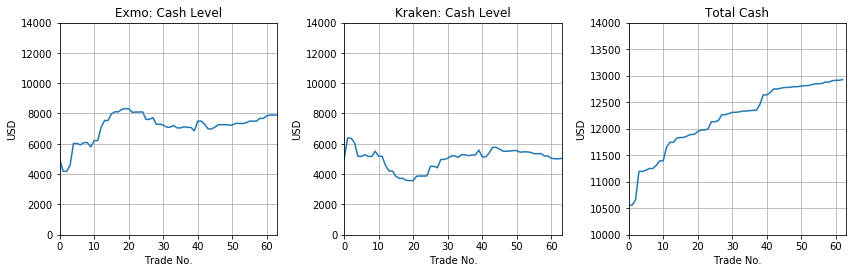

In [14]:
plt.figure(figsize=(12,7))
 
plt.subplot(2,3,1)
plt.plot(ac1)
plt.title("Exmo: Cash Level")
plt.xlabel("Trade No."); plt.ylabel("USD")
plt.grid()
plt.xlim([0, len(money)])
plt.ylim([0, 14001])
 
plt.subplot(2,3,2)
plt.plot(ac2)
plt.title("Kraken: Cash Level")
plt.xlabel("Trade No."); plt.ylabel("USD")
plt.grid()
plt.xlim([0, len(money)])
plt.ylim([0, 14001])
 
plt.subplot(2,3,3)
plt.plot(np.array(money))
plt.title("Total Cash")
plt.xlabel("Trade No."); plt.ylabel("USD")
plt.grid()
plt.xlim([0, len(money)])
plt.ylim([investment, 14000])
 
plt.tight_layout()
plt.savefig('cashlevels.png', bbox_inches='tight')
